# Geolocalisation Challenge

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import os
import sys

In [3]:
os.chdir('..') ; sys.path.append(os.getcwd())

print(os.getcwd())

/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge


### Building features

In [3]:
from utils.features_builder import Builder

In [4]:
train_path = 'data/Train/train_dataset.csv'
train_data = pd.read_csv(train_path, sep=',')

train_data.head()

,Unnamed: 0,Unnamed: 0.1,messageid,latitude,longitude,did,did_hex,time_msg,time_ux,time_ux_client,...,radius,datepart,seqnumber,dtid,nseq,rssi,bsid_hex,bsid,snr,freq
0,1,12406538,5b216b5ae541cd3845b8c2c5,48.984978,2.361960,5132655,4E516F,2018-06-13 19:07:06,1528916826000,1.528917e+12,...,NaN,2018-06-13,835,5491a93b9336908c3b1b4c70,0,-134,2035,8245,10.890000,868192913
1,2,9069667,5addfec9e541cd123f0bd3f5,48.837357,2.483158,5140851,4E7173,2018-04-23 15:42:01,1524498121000,1.524498e+12,...,NaN,2018-04-23,103,5491a93b9336908c3b1b4c70,0,-104,3ED2,16082,47.549999,868134621
2,3,7404394,5a74bdcf12f14352d21e92a9,48.862305,2.366602,5136312,4E5FB8,2018-02-02 19:36:47,1517600207000,1.517600e+12,...,NaN,2018-02-02,570,5491a93b9336908c3b1b4c70,0,-106,DEA,3562,45.070000,868139828
3,5,9104930,5b06b5e1e541cd05fd935cda,48.978531,2.387568,5134613,4E5915,2018-05-24 12:53:53,1527166433000,1.527166e+12,...,NaN,2018-05-24,1174,5491a93b9336908c3b1b4c70,0,-139,37C8,14280,7.690000,868051002
4,6,5185493,5ae5b900cf554f6aa996a3da,48.876232,2.380044,5141682,4E74B2,2018-04-29 12:22:24,1525004544000,1.525005e+12,...,NaN,2018-04-29,629,5491a93b9336908c3b1b4c70,0,-124,6CF,1743,17.940001,868109215


In [5]:
clt_cols = ['dtid', 'time_ux_client', 'motion', 'speed', 'data_type', 'radius', 'seqnumber']

bs_cols = ['nseq', 'rssi', 'snr', 'freq', 'time_ux']

builder = Builder('messageid', 'bsid', clt_cols, bs_cols, 500)

builder.client_features(train_data)

builder.gb_bs_features(train_data)


Shape of df_groupby: (10024673, 5)


nseq  rssi        snr       freq  \
messageid                bsid                                      
5a497a24cf554f30e846c069 1796      0  -124  27.570000  868161790   
                         1859      0  -134  17.559999  868162324   
                         2846      0  -122  29.330000  868162333   
                         3378      0  -137  14.450000  868161847   
                         3414      0  -115  36.209999  868161902   
                         3570      0  -133  18.420000  868161463   
                         3581      0  -109  42.459999  868161386   
                         4058      0  -116  34.910000  868161622   
                         4078      0  -138  13.580000  868162679   
                         8245      0  -121  29.790001  868161527   
                         8437      0  -125  26.320000  868161778   
5a497a4ce541cd714d45b1c5 1476      0  -100  51.110001  868141945   
                         1796      0  -140  11.390000  868142058   
                         3563      0  -133  17.959999  868141942   
                         3578      0  -103  47.700001  868141980   
                         8472      0  -115  36.540001  868142269   
                         14280     0  -139  12.020000  868141870   
5a497a4dcf554f30e8472041 2768      0  -141  10.580000  868105359   
                         3357      0  -131  20.450001  868104524   
                         3412      0  -124  27.570000  868104900   
                         3545      0  -116  35.299999  868104520   
                         3565      0  -126  25.129999  868104935   
                         8475      0  -130  20.650000  868104421   
5a497aafcf554f30e847cc61 2605      0  -128  23.410000  868053645   
                         2707      0  -114  37.389999  868052773   
                         2846      0  -107  44.380001  868053017   
                         3025      0  -107  44.349998  868052874   
                         3526      0  -118  32.810001  868052650   
                         3581      0  -113  38.180000  868052071   
                         4058      0  -119  32.540001  868052304   
...                              ...   ...        ...        ...   
5b45481ccf554f42c39de904 3578      0  -131  14.090000  868177549   
                         3579      0  -111  23.420000  868177472   
                         4058      0  -126   8.840000  868177354   
                         4059      0  -130  11.210000  868177296   
                         4129      0  -121  11.980000  868177459   
                         4993      0  -126  17.309999  868177289   
                         7248      0  -125  20.150000  868178021   
                         8364      0  -120  23.740000  868177590   
                         8446      0  -127  18.770000  868177464   
                         8472      0  -132  10.890000  868177666   
                         10151     0  -132  15.290000  868177126   
                         10162     0  -126  18.299999  868177138   
                         10942     0  -119  22.430000  868177309   
                         27486     0  -123  22.320000  868177038   
5b454825cf554f42c39e0605 1859      0  -121  15.260000  868066920   
                         2605      0  -134   9.940000  868067690   
                         2846      0  -134   9.620000  868066718   
                         3547      0  -131   7.280000  868066434   
                         3570      0  -128  15.910000  868066129   
                         3581      0   -97  19.709999  868065960   
                         4058      0  -123  14.720000  868066165   
                         8370      0  -131  15.140000  868066246   
                         28233     0  -143   6.830000  868065815   
5b45482ae541cd394f380deb 1872      0  -132  14.520000  868186986   
                         1878      0  -123  19.110001  868187237   
                         2790      0  -128  14.870000  868187374   
                    

In [6]:
df_bs_features = builder.fast_bs_features(30)

df_features = pd.concat([builder.df_features_, df_bs_features], axis=1)

df_features.head()

0.052% of database parsed
0.104% of database parsed
0.157% of database parsed
0.209% of database parsed
0.261% of database parsed
0.313% of database parsed
0.366% of database parsed
0.418% of database parsed
0.470% of database parsed
0.522% of database parsed
0.574% of database parsed
0.627% of database parsed
0.679% of database parsed
0.731% of database parsed
0.783% of database parsed
0.835% of database parsed
0.888% of database parsed
0.940% of database parsed
0.992% of database parsed
1.044% of database parsed
1.097% of database parsed
1.149% of database parsed
1.201% of database parsed
1.253% of database parsed
1.305% of database parsed
1.358% of database parsed
1.410% of database parsed
1.462% of database parsed
1.514% of database parsed
1.566% of database parsed
1.619% of database parsed
1.671% of database parsed
1.723% of database parsed
1.775% of database parsed
1.828% of database parsed
1.880% of database parsed
1.932% of database parsed
1.984% of database parsed
2.036% of da

16.291% of database parsed
16.344% of database parsed
16.396% of database parsed
16.448% of database parsed
16.500% of database parsed
16.552% of database parsed
16.605% of database parsed
16.657% of database parsed
16.709% of database parsed
16.761% of database parsed
16.813% of database parsed
16.866% of database parsed
16.918% of database parsed
16.970% of database parsed
17.022% of database parsed
17.075% of database parsed
17.127% of database parsed
17.179% of database parsed
17.231% of database parsed
17.283% of database parsed
17.336% of database parsed
17.388% of database parsed
17.440% of database parsed
17.492% of database parsed
17.544% of database parsed
17.597% of database parsed
17.649% of database parsed
17.701% of database parsed
17.753% of database parsed
17.806% of database parsed
17.858% of database parsed
17.910% of database parsed
17.962% of database parsed
18.014% of database parsed
18.067% of database parsed
18.119% of database parsed
18.171% of database parsed
1

32.165% of database parsed
32.217% of database parsed
32.269% of database parsed
32.321% of database parsed
32.374% of database parsed
32.426% of database parsed
32.478% of database parsed
32.530% of database parsed
32.583% of database parsed
32.635% of database parsed
32.687% of database parsed
32.739% of database parsed
32.791% of database parsed
32.844% of database parsed
32.896% of database parsed
32.948% of database parsed
33.000% of database parsed
33.053% of database parsed
33.105% of database parsed
33.157% of database parsed
33.209% of database parsed
33.261% of database parsed
33.314% of database parsed
33.366% of database parsed
33.418% of database parsed
33.470% of database parsed
33.522% of database parsed
33.575% of database parsed
33.627% of database parsed
33.679% of database parsed
33.731% of database parsed
33.784% of database parsed
33.836% of database parsed
33.888% of database parsed
33.940% of database parsed
33.992% of database parsed
34.045% of database parsed
3

13.524% of database parsed
13.576% of database parsed
13.628% of database parsed
13.681% of database parsed
13.733% of database parsed
13.785% of database parsed
13.837% of database parsed
13.889% of database parsed
13.942% of database parsed
13.994% of database parsed
14.046% of database parsed
14.098% of database parsed
14.150% of database parsed
14.203% of database parsed
14.255% of database parsed
14.307% of database parsed
14.359% of database parsed
14.412% of database parsed
14.464% of database parsed
14.516% of database parsed
14.568% of database parsed
14.620% of database parsed
14.673% of database parsed
14.725% of database parsed
14.777% of database parsed
14.829% of database parsed
14.881% of database parsed
14.934% of database parsed
14.986% of database parsed
15.038% of database parsed
15.090% of database parsed
15.143% of database parsed
15.195% of database parsed
15.247% of database parsed
15.299% of database parsed
15.351% of database parsed
15.404% of database parsed
1

29.397% of database parsed
29.450% of database parsed
29.502% of database parsed
29.554% of database parsed
29.606% of database parsed
29.658% of database parsed
29.711% of database parsed
29.763% of database parsed
29.815% of database parsed
29.867% of database parsed
29.920% of database parsed
29.972% of database parsed
30.024% of database parsed
30.076% of database parsed
30.128% of database parsed
30.181% of database parsed
30.233% of database parsed
30.285% of database parsed
30.337% of database parsed
30.390% of database parsed
30.442% of database parsed
30.494% of database parsed
30.546% of database parsed
30.598% of database parsed
30.651% of database parsed
30.703% of database parsed
30.755% of database parsed
30.807% of database parsed
30.859% of database parsed
30.912% of database parsed
30.964% of database parsed
31.016% of database parsed
31.068% of database parsed
31.121% of database parsed
31.173% of database parsed
31.225% of database parsed
31.277% of database parsed
3

10.756% of database parsed
10.809% of database parsed
10.861% of database parsed
10.913% of database parsed
10.965% of database parsed
11.018% of database parsed
11.070% of database parsed
11.122% of database parsed
11.174% of database parsed
11.226% of database parsed
11.279% of database parsed
11.331% of database parsed
11.383% of database parsed
11.435% of database parsed
11.487% of database parsed
11.540% of database parsed
11.592% of database parsed
11.644% of database parsed
11.696% of database parsed
11.749% of database parsed
11.801% of database parsed
11.853% of database parsed
11.905% of database parsed
11.957% of database parsed
12.010% of database parsed
12.062% of database parsed
12.114% of database parsed
12.166% of database parsed
12.218% of database parsed
12.271% of database parsed
12.323% of database parsed
12.375% of database parsed
12.427% of database parsed
12.480% of database parsed
12.532% of database parsed
12.584% of database parsed
12.636% of database parsed
1

26.630% of database parsed
26.682% of database parsed
26.734% of database parsed
26.787% of database parsed
26.839% of database parsed
26.891% of database parsed
26.943% of database parsed
26.996% of database parsed
27.048% of database parsed
27.100% of database parsed
27.152% of database parsed
27.204% of database parsed
27.257% of database parsed
27.309% of database parsed
27.361% of database parsed
27.413% of database parsed
27.465% of database parsed
27.518% of database parsed
27.570% of database parsed
27.622% of database parsed
27.674% of database parsed
27.727% of database parsed
27.779% of database parsed
27.831% of database parsed
27.883% of database parsed
27.935% of database parsed
27.988% of database parsed
28.040% of database parsed
28.092% of database parsed
28.144% of database parsed
28.196% of database parsed
28.249% of database parsed
28.301% of database parsed
28.353% of database parsed
28.405% of database parsed
28.458% of database parsed
28.510% of database parsed
2

In [ ]:
df_features.head()

In [ ]:
# reindex df_features for future merge
df_features.set_index('messageid', inplace=True)

In [6]:
# checking consistency of features
df_features.shape, train_labels.shape

((2298059, 8), (2298059, 2))

In [ ]:
train_labels = train_data[['messageid', ' latitude', 'longitude']] \
    .groupby('messageid', as_index=True).first()
    
Xy = df_features.merge(train_labels)

Xy.head()

In [ ]:
# free disk space
del df_client_features, df_bs_features, builder
import gc ; gc.collect() ; del  gc

## Feature engineering

This step consists in transforming the features in vectors, ie removing NaN values, transforming columns etc...

Further are described in `feature_exploration.ipynb` notebook as well as there distributions and types

### By column

In [ ]:
# client specific features
# dtid -> one hot encoding , 0% missing values

# motion: bool  when t = 1 else 0  , 21% Nan: input majority (0)
# speed: numeric, 21% NaN, input(0) (corresponds to missing `motion` so it is set to 0)
Xy['motion'] = Xy['motion'].apply(lambda u: 1 if u == 't' else 0)
Xy.fillna({'motion': 0, 'speed': 0}, inplace=True)

# data-type -> one-hot encoding, 0% missing values
dtype_ohe = pd.get_dummies(Xy['data-type'])
Xy.drop('data-type', axis=1, inplace=True)
Xy = pd.concat([Xy, dtype_ohe], axis=1)


# radius, numeric, 82% missing values input median
radius_median = Xy['radius'].median()
Xy.fillna({'radius': radius_median}, inplace=True)

# seqnumber, numeric, 0% NaN, nothing to do


In [ ]:
# creating column `delay` : (time_ux_bsid - time_ux_client)
time_columns = ['time_ux{}'.format(bsid) for bsid in bsids]

for time_column in time_columns:
    Xy[time_column] = (Xy[time_column] // 1000 - Xy['time_ux_client'] // 1000)

Xy.drop('time_ux_client', axis=1, inplace=True) # useful ? maybe cut in hour

### From HDF5 or Parquet

In [7]:
Xy = pd.read_parquet('data/feature_matrix_train_v0.parquet')

Xy.head()

,dtid,motion,speed,radius,seqnumber,nseq8245,nseq16082,nseq3562,nseq14280,nseq1743,...,time_ux1253,time_ux27386,time_ux24929,time_ux15085,latitude,longitude,fast,gps,priv,wifi
5a497a24cf554f30e846c069,5491a93b9336908c3b1b4c70,0,1.0,0.0,283,0.0,0.0,0.0,0.0,0.0,...,-1.514765e+09,-1.514765e+09,-1.514765e+09,-1.514765e+09,48.909265,2.310304,0,1,0,0
5a497a4ce541cd714d45b1c5,5491a93b9336908c3b1b4c70,0,1.0,0.0,194,0.0,0.0,0.0,0.0,0.0,...,-1.514765e+09,-1.514765e+09,-1.514765e+09,-1.514765e+09,49.009068,2.351928,0,1,0,0
5a497a4dcf554f30e8472041,5491a93b9336908c3b1b4c70,0,0.0,0.0,2598,0.0,0.0,0.0,0.0,0.0,...,-1.514765e+09,-1.514765e+09,-1.514765e+09,-1.514765e+09,48.804501,2.427322,0,1,0,0
5a497aafcf554f30e847cc61,5491a93b9336908c3b1b4c70,0,0.0,0.0,2721,0.0,0.0,0.0,0.0,0.0,...,-1.514765e+09,-1.514765e+09,-1.514765e+09,-1.514765e+09,48.965332,2.238364,0,1,0,0
5a497adde541cd714d46accb,5491a93b9336908c3b1b4c70,0,1.0,0.0,1898,0.0,0.0,0.0,0.0,0.0,...,-1.514765e+09,-1.514765e+09,-1.514765e+09,-1.514765e+09,48.978103,2.320644,0,1,0,0


In [8]:
dtid_ohe = pd.get_dummies(Xy['dtid'])
Xy.drop('dtid', axis=1, inplace=True)
Xy = pd.concat([Xy, dtid_ohe], axis=1)

Xy.head()

,motion,speed,radius,seqnumber,nseq8245,nseq16082,nseq3562,nseq14280,nseq1743,nseq3558,...,5aa2b2e95005741b7d664456,5aafc3cf9e93a13199a1d3e0,5ad494bd9e93a128c8abfca4,5ad49def3c87894334c6d764,5ad7077f9e93a128c85029d7,5af2bdf49e93a128c8cbbc19,5afbe2c59058c264249ac174,5afd4b7c9058c26424f713c5,5b0ef3125005747bb07f99eb,5b115d0b9058c20630b137df
5a497a24cf554f30e846c069,0,1.0,0.0,283,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5a497a4ce541cd714d45b1c5,0,1.0,0.0,194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5a497a4dcf554f30e8472041,0,0.0,0.0,2598,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5a497aafcf554f30e847cc61,0,0.0,0.0,2721,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5a497adde541cd714d46accb,0,1.0,0.0,1898,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


There are no missing values in bs specific features, meaning our feature matrix is ready

## Training a model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from utils.evaluation import vincenty_df, vincenty_vec, criterion, plot_error
from geopy.distance import vincenty

In [11]:
features = list(Xy.columns)
features.remove('latitude')
features.remove('longitude')

In [18]:
X, y = Xy.loc[:, features], Xy.loc[:, ['latitude', 'longitude']]
X_scale = StandardScaler().fit_transform(X)

x_train, x_test, y_train, y_test = \
    train_test_split(X_scale, y, test_size=0.1, random_state=0)

/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
x_train.shape, y_train.shape

((861810, 832), (861810, 2))

In [ ]:
lr = LinearRegression(n_jobs=16)
lr.fit(x_train, y_train)

rf = RandomForestRegressor(n_estimators=100, n_jobs=16, verbose=3).fit(x_train, y_train)

In [32]:
pred_lr = pd.DataFrame(lr.predict(x_test), columns=['pred_lat', 'pred_long'])
# pred_lr['messageid'] = x_test.index

pred_rf = pd.DataFrame(rf.predict(x_test), columns=['pred_lat', 'pred_long'])
# pred_rf['messageid'] = x_test.index

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    2.0s finished


In [38]:
pred_lr[['pred_lat', 'pred_long']].values.shape, y_test.shape

((95757, 2), (95757, 2))

In [41]:
df_ytest = pd.DataFrame(y_test, columns=['latitude', 'longitude'])

In [46]:
pred_rf.min()

pred_lat     46.326156
pred_long    -1.186491
dtype: float64

In [47]:
# print('criterion for logistic regression: {:.3f}'\
#       .format(criterion(pred_lr[['pred_lat', 'pred_long']], df_ytest, True)))
      
print('criterion for random forest: {:.3f}'\
      .format(criterion(pred_rf[['pred_lat', 'pred_long']], df_ytest, True)))

criterion for random forest: 5.959


In [ ]:
plot_error(x_test, pred_lr['prediction'], True)

/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


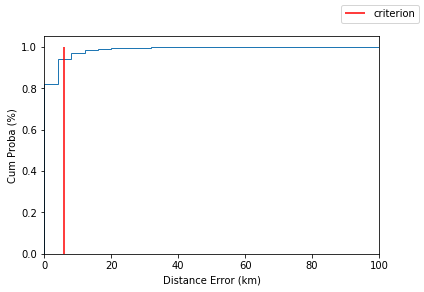

In [50]:
plot_error(df_ytest, pred_rf[['pred_lat', 'pred_long']], True)

Now trying xgboost

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

xgb_regressor = xgb.XGBRegressor(n_jobs=16)
xgb.fit(x_train, y_train, eval_metric=vincenty_vec)